# Doc2Vec
- Word2Vec의 확장판 모델 
- 기본적인 매개변수, 속성, 메서드는 Word2Vec과 같다. 
- 추가적인 부분이 생성 

- 매개변수 
    - dm 
        - 기본값이 1
        - 학습 알고리즘을 선택 
        - 1 : PV-DM 
        - 0 : PT-DBOW
    - dm_mean 
        - 기본값 : 0
        - PV-DM에서 문장 벡터의 계산 방식 
        - 0 : 벡터들의 합산 -> 범위가 커지는 경우가 발생 -> 노이즈로 인한 성능의 저하가 발생 할수 있음
        - 1 : 벡터들의 평균
    - dm_concat
        - 기본값 : 0
        - PV-DM에서 문서 벡터와 문장 벡터를 결합할것인가?
        - 결합을 하는 경우 차원이 급격하게 증가 
    - dbow_words
        - 기본값 : 0
        - PV-DBOW 사용 시 단어 벡터도 동시에 학습할것인가(Skip-gram 방식과 흡사)
- 속성 
    - model.wv 
        - 학습이 된 단어 벡터의 저장소
    - model.dv
        - 학습이 된 문장의 벡터의 저장소 
    - model.dv.index_to_key
        - 문서들의 ID값 리스트
- 메서드 
    - build_vocab()
        - 단어  / 문서 사전을 구성
    - train()
        - 사전이 구축이 된 뒤 직접 학습을 수행 

- build_vocab(), train() 메서드를 이용하여 수동으로 학습을 설정 
- 일반적으로는 Doc2Vec 객체를 생성할때 사전의 생성과 학습
- 증분 학습에서 사용이 되는 부분
    - 기존에 학습이 된 모델에 새로운 데이터셋을 추가 
    - 데이터의 양이 증가하면 성능이 오를수 있는 확률이 존재
    - 기존의 학습 시킨 데이터와 유사한 데이터를 증분학습하여 성능을 향상

In [1]:
# gensim 라이브러리 안에 Doc2Vec를 이용하여 임베딩 
from konlpy.tag import Komoran
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import re


In [2]:
# 샘플 데이터를 2개의 유형 문장들로 구성 
docs = [
    "나는 커피를 정말 좋아한다", 
    "오늘 아침에 에스프레소 두 잔을 마셨다", 
    '카페라떼가 제일 맛있다고 생각한다', 
    '나는 차를 더 자주 마신다', 
    '녹차를 마시면 기분이 편안해진다', 
    '홍차는 향이 깊고 고급스러운 느낌이다', 
    '카페에서 책을 읽는 시간이 너무 좋다', 
    '허브티도 몸에 좋은거 같다'
]

In [8]:
# 형태소 분석 Komoran을 이용하여 토큰화 
komoran = Komoran()

# 특정 품사만 사용 
allow_pos = [ 'NNP', 'NNG', 'VV', 'VA', 'MAG', 'XR' ]
# 불용어 
stop_word = ['하다', '되다', '이다', '것', '수', '거']

# 문자에서 불필요한 글자들을 제거 (정규화)
def nomalize(text):
    # 특수문자 제외 , 공백에 대한 처리 
    text = re.sub(r"[^가-힣0-9a-zA-Z\s\.]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 토큰화 함수를 정의 
def tokenize(text):
    # 문자의 정규화 함수를 호출 
    text = nomalize(text)

    tokens = []
    for word, pos in komoran.pos(text):
        if pos in allow_pos:
            # 길이를 체크하기 전에 동사, 형용사 에는 '다' 붙이기 활용
            if pos in ['VV', 'VA']:
                word += '다'
            if word not in stop_word and len(word) > 1:
                # allow_pos의 포함되어있고
                # stop_word에 포함되어있지 않으며
                # 단어의 길이가 1보다 큰 문자만 활용
                tokens.append(word)
    return tokens

In [9]:
tokenize_docs = [ tokenize(doc) for doc in docs ]
tokenize_docs

[['커피', '정말', '좋아하다'],
 ['오늘', '아침', '에스프레소', '마시다'],
 ['카페', '제일', '맛있다', '생각'],
 ['자주', '마시다'],
 ['녹차', '마시다', '기분', '편안'],
 ['홍차', '깊다', '고급', '느낌'],
 ['카페', '읽다', '시간', '너무', '좋다'],
 ['허브', '좋다', '같다']]

In [ ]:
# 문장 별로 ID 를 지정 
tagged = []
for idx, toks in enumerate(tokenize_docs):
    # TaggedDcoumnt를 이용하여 문장 당 ID 을 부여하고 tagged에 추가 
    tagged.append(
        TaggedDocument(words = toks, tags=[f"DOC_{idx}"])
    )
tagged

In [12]:
# tag을 추가한 문서를 이용해서 Doc2Vec 모델에 학습 데이터로 이용
model = Doc2Vec(
    documents= tagged, 
    vector_size= 120, 
    window= 5, 
    min_count = 1,   # 데이터의 개수가 작기 때문, 실제 3-5
    dm = 1,    # PV-DM 방식
    dm_mean = 1,    # 벡터들의 평균(범위를 크지 않게 잡아서 안정적)
    negative = 5,   # 잘못된 단어간의 배치를 사용하여 학습에 이용
    epochs= 50, 
    seed = 42
)

In [13]:
print("학습이 된 문장의 개수", len(model.dv))

학습이 된 문장의 개수 8


In [ ]:
# 문장 간의 유사도를 수치적으로 확인 
def print_similities(doc_id):
    # 수정1
    dic_vec = model.dv[f"DOC_{doc_id}"]

    # doc_id : 문서의 tag 이름
    # 각각의 문장들의 벡터 데이터를 리스트로 생성
    mat = np.vstack(
        [model.dv[f"DOC_{i}"] for i in range(len(docs))]
    )
    # 코사인 유사도 사용
    # 수정2
    sims = cosine_similarity( [dic_vec], mat )[0]

    order = sims.argsort()[::-1]

    # 수정 3
    print(f"기존의 문장 : {doc_id} -> {docs[doc_id]}" )
    for idx in order:
        print( f"   -> {idx} {docs[idx]}   |  cos = {sims[idx]}" )

print_similities(0)

기존의 문장 : 0 -> 나는 커피를 정말 좋아한다
   -> 0 나는 커피를 정말 좋아한다   |  cos = 1.0
   -> 7 허브티도 몸에 좋은거 같다   |  cos = 0.1954648792743683
   -> 1 오늘 아침에 에스프레소 두 잔을 마셨다   |  cos = 0.13140203058719635
   -> 3 나는 차를 더 자주 마신다   |  cos = 0.06367944180965424
   -> 6 카페에서 책을 읽는 시간이 너무 좋다   |  cos = 0.01677805185317993
   -> 4 녹차를 마시면 기분이 편안해진다   |  cos = 0.007417656481266022
   -> 2 카페라떼가 제일 맛있다고 생각한다   |  cos = -0.06176169961690903
   -> 5 홍차는 향이 깊고 고급스러운 느낌이다   |  cos = -0.11510717123746872


In [18]:
# 차원 축소 기법을 이용해서 그래프 시각화 
# 각 문장들 간에 거리를 확인 
from sklearn.manifold import TSNE

In [21]:
# 차원 축소를 하기 위해서는 -> 고차원의 데이터 필요
X = np.vstack(
    [model.dv[f"DOC_{idx}"] for idx in range(len(docs))]
)
X.shape

(8, 120)

In [22]:
# t-SNE를 이용하여 2D 변경 
tsne = TSNE(
    n_components=2, 
    perplexity=5, 
    max_iter=2000, 
    random_state=42
)

In [23]:
# 차원 축소 모델에 학습을 시키고 데이터를 변형한다. 
X_2d = tsne.fit_transform(X)

In [24]:
X_2d.shape

(8, 2)

In [25]:
import matplotlib.pyplot as plt

In [31]:
# 그래프는 산점도 그래프 
# 각각의 점에 주석 추가 -> 해당 위치의 문장의 데이터
# 문장들이 한글 -> 기본적인 matplot 폰트에서는 한글 지원X -> 폰트를 변경
# 각각의 os에 따라서 폰트 설정이 다름
import platform 

if platform.system() == 'Darwin':
    plt.rc('font', family= 'AppleGothic')
else:
    plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐의 방지 
plt.rcParams['axes.unicode_minus'] = False

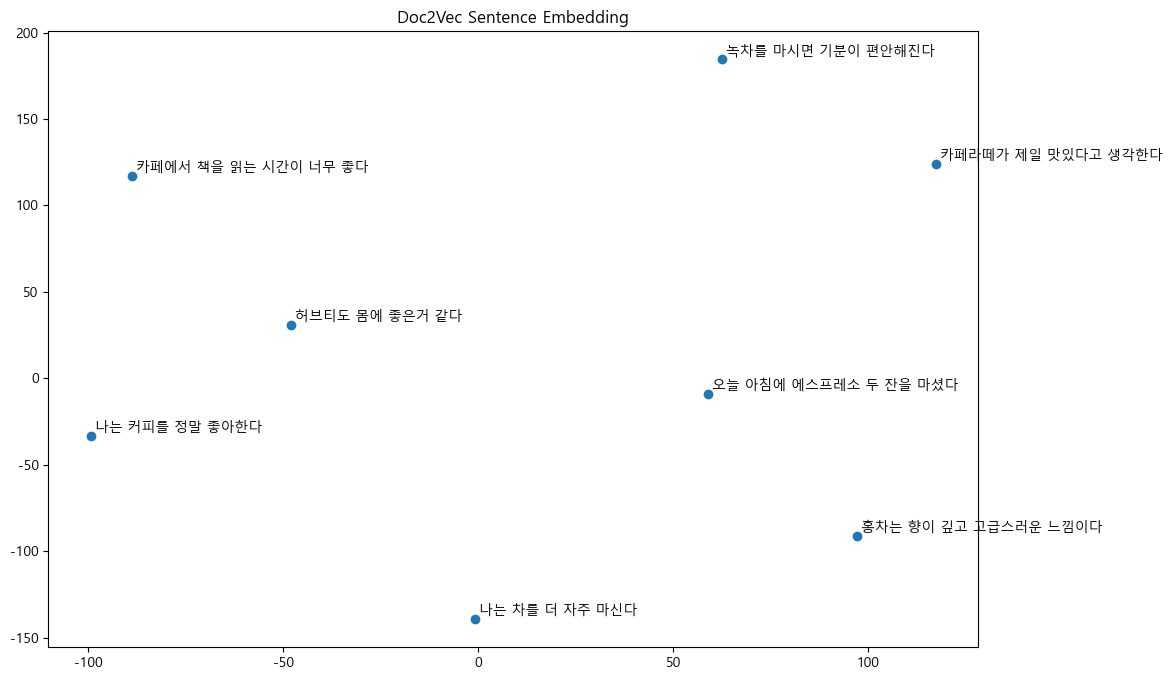

In [32]:
plt.figure(figsize=(12, 8))
# 산점도 그래프를 생성 -> X축 데이터, Y축 데이터 -> 
# X_2d의 첫번째 열과 두번째 열의 데이터
plt.scatter(X_2d[:, 0], X_2d[:, 1])

# 각각의 점들에 문장 데이터를 주석으로 추가 
for idx, text in enumerate(docs):
    plt.annotate(
        text, 
        # 주석의 원 데이터의 위치 
        xy= (X_2d[idx, 0] , X_2d[idx, 1]), 
        # 주석의 위치
        xytext= (3, 3), 
        textcoords='offset points'  # 각각의 위치에 텍스트 대입
    )

plt.title('Doc2Vec Sentence Embedding')
plt.show()